In [2]:
import sys
sys.path.insert(0, './utils/')
from helper_functions import *
from Config import Config

import glob
import time

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import cv2
from PIL import Image
from moviepy.editor import VideoFileClip

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

seed = 0

# Load images and visualize:

In [3]:
cars = glob.glob('./dataset/vehicles/**/*.png')
num_car_image = len(cars)

notcars = glob.glob('./dataset/non-vehicles/**/*.png')
num_not_car_image = len(notcars)

print('# car images:', num_car_image, '\n# non-car images:', num_not_car_image)

# car images: 8792 
# non-car images: 8968


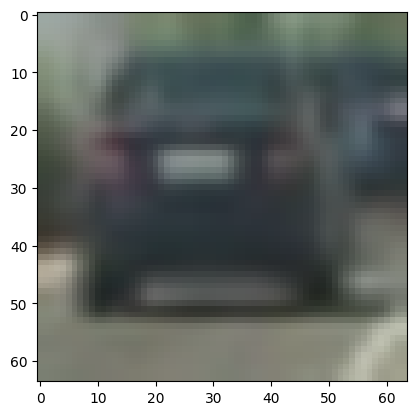

In [4]:
image_test1 = np.asarray(Image.open(cars[0]))
plt.imshow(image_test1)

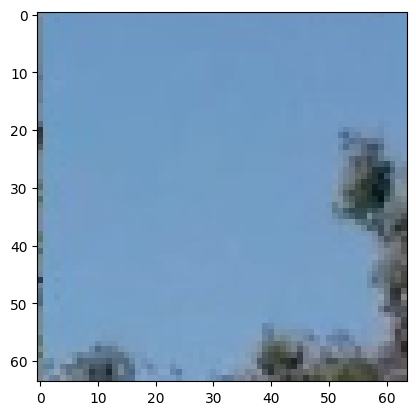

In [5]:
image_test2 = np.asarray(Image.open(notcars[0]))
plt.imshow(image_test2)

In [6]:
for i in range(len(cars)):
    cars[i] = np.asarray(Image.open(cars[i]))

for i in range(len(notcars)):
    notcars[i] = np.asarray(Image.open(notcars[i]))

# Training the Model:

In [7]:
car_features = extract_features(cars, 
                                Config.color_space, Config.spatial_size, 
                                Config.hist_bins, Config.orient,
                                Config.pix_per_cell, Config.cell_per_block,
                                Config.hog_channel, Config.spatial_feat,
                                Config.hist_feat, Config.hog_feat)

notcar_features = extract_features(notcars,
                                   Config.color_space, Config.spatial_size,
                                   Config.hist_bins, Config.orient,
                                   Config.pix_per_cell, Config.cell_per_block,
                                   Config.hog_channel, Config.spatial_feat,
                                   Config.hist_feat, Config.hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64) 

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

    
print('Feature vector length:', len(X_train[0]))

Feature vector length: 6108


## Decision Tree Classifier

In [9]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
print('Test Accuracy of Model = ', round(tree.score(X_test, y_test), 4))

Test Accuracy of Model =  0.9665


## Random Forest Classifier

In [10]:
forest = RandomForestClassifier()

forest.fit(X_train, y_train)

print('Test Accuracy of Model = ', round(forest.score(X_test, y_test), 4))

Test Accuracy of Model =  0.993


## SVM Classifier

In [11]:
svm = LinearSVC()

svm.fit(X_train, y_train)

print('Test Accuracy of Model = ', round(svm.score(X_test, y_test), 4))

Test Accuracy of Model =  0.9932


## XGBoost Classifier

In [12]:
import xgboost as xgb
model = xgb.XGBClassifier()

model.fit(X_train, y_train)

print('Test Accuracy of Model = ', round(model.score(X_test, y_test), 4))

Test Accuracy of Model =  0.9961


## Classification Report for XGBoost Classifier

In [13]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1829
         1.0       1.00      0.99      1.00      1723

    accuracy                           1.00      3552
   macro avg       1.00      1.00      1.00      3552
weighted avg       1.00      1.00      1.00      3552



# Test on one image

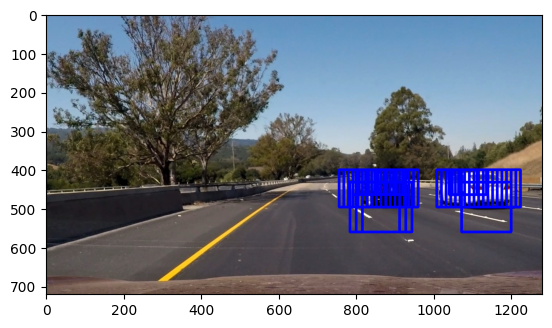

In [14]:
img = np.asarray(Image.open('./dataset/test_images/test6.jpg'))

out_img, box_list = find_cars(img, model, X_scaler, Config.y_start_stops, Config.scales, Config.window,
                              Config.color_space, Config.spatial_size,
                              Config.hist_bins, Config.orient,
                              Config.pix_per_cell, Config.cell_per_block,
                              Config.hog_channel, Config.spatial_feat,
                              Config.hist_feat, Config.hog_feat)

plt.imshow(out_img)

# Main Pipeline

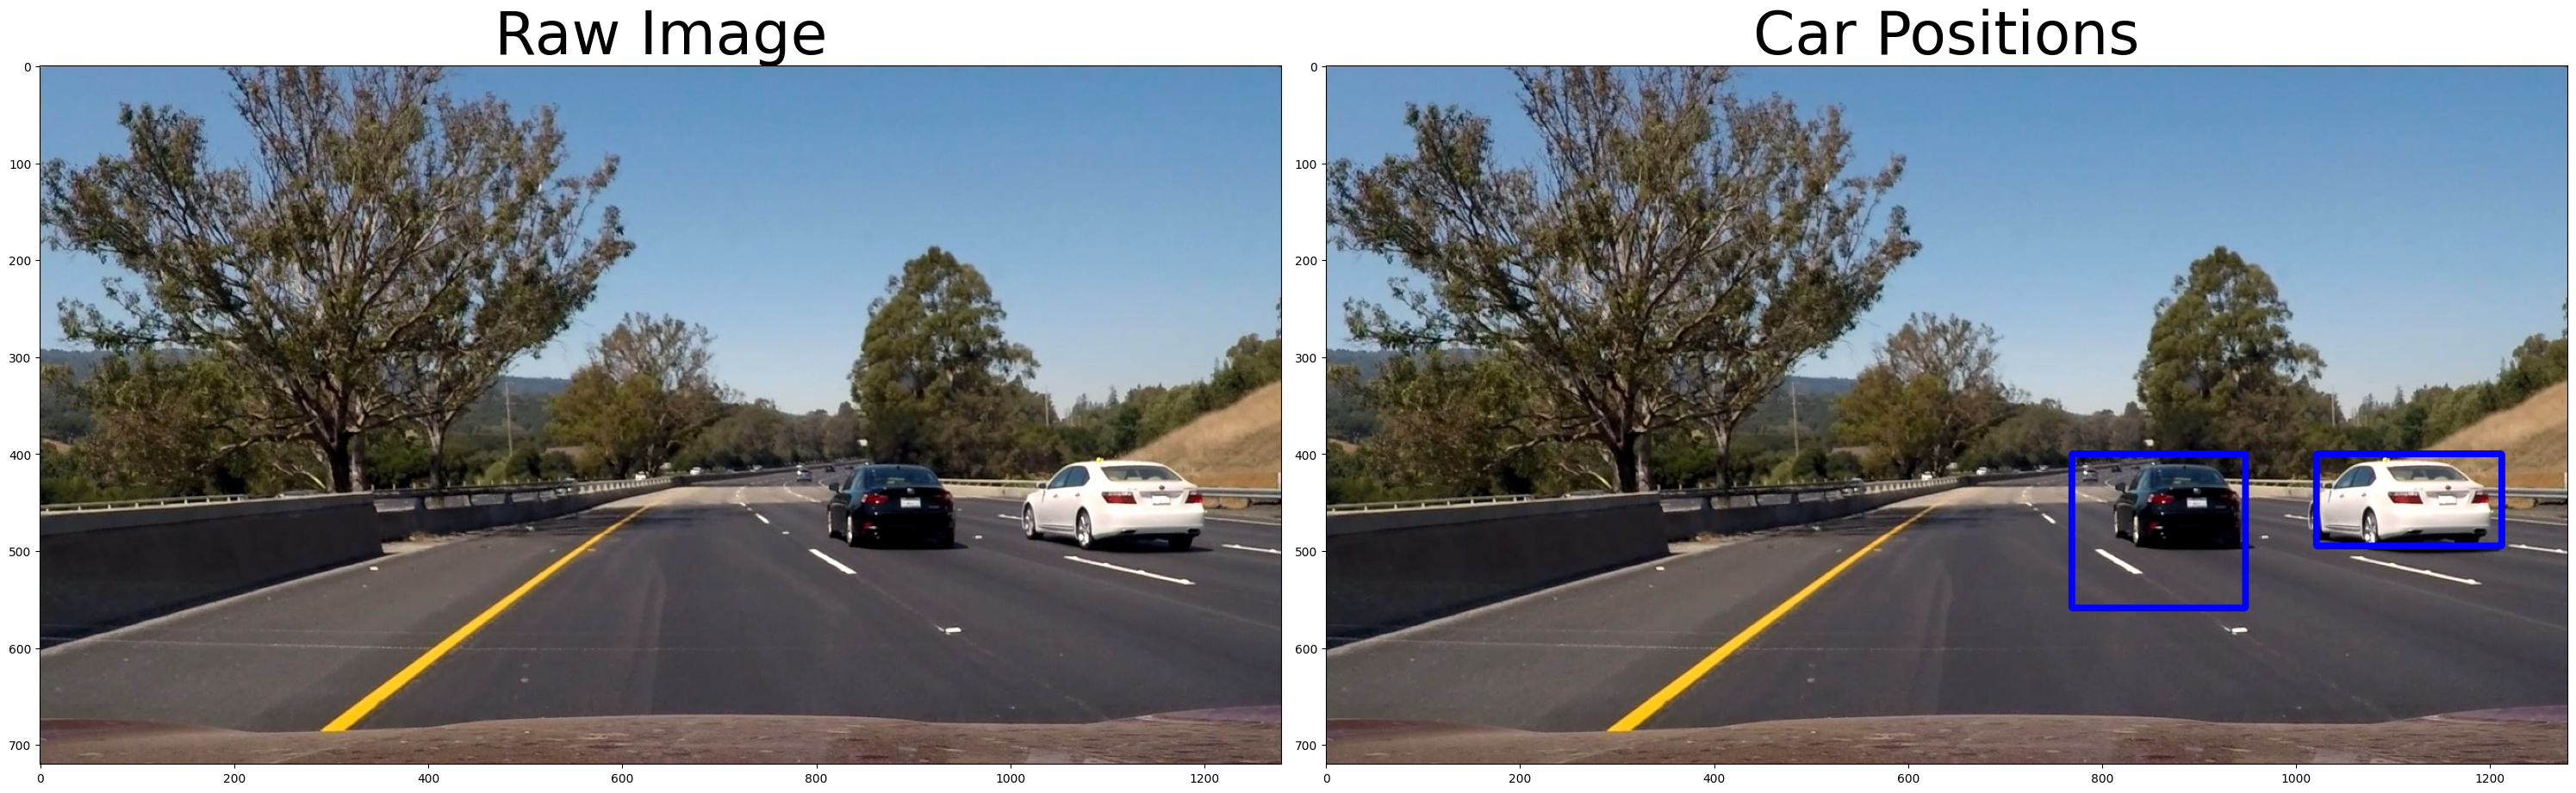

In [15]:
def main_pipeline(img):
    out_img, box_list = find_cars(img, model, X_scaler, Config.y_start_stops, Config.scales, Config.window,
                              Config.color_space, Config.spatial_size,
                              Config.hist_bins, Config.orient,
                              Config.pix_per_cell, Config.cell_per_block,
                              Config.hog_channel, Config.spatial_feat,
                              Config.hist_feat, Config.hog_feat)
    
    heatmap = np.zeros_like(img[:,:,0]).astype(float)
    heatmap = add_heat(heatmap, box_list)
    heatmap = apply_threshold(heatmap, 2)

    # Find final boxes from heatmap using label function
    labels = label(heatmap, return_num=True)
    draw_img = draw_labeled_bboxes(img, labels)
    return draw_img

image = np.asarray(Image.open('./dataset/test_images/test6.jpg'))
draw_img = main_pipeline(image)

fig = plt.figure(figsize=(30,20))
plt.subplot(121)
plt.imshow(image)
plt.title('Raw Image', {'fontsize': 50})
plt.subplot(122)
plt.imshow(draw_img)
plt.title('Car Positions', {'fontsize': 50})
fig.tight_layout()

# Test on video

In [16]:
# white_output = 'project_video_output.mp4'
# clip1 = VideoFileClip("project_video.mp4").subclip(0,20)
# white_clip = clip1.fl_image(main_pipeline) #NOTE: this function expects color images!!
# %time white_clip.write_videofile(white_output, audio=False)